<a href="https://colab.research.google.com/github/misha345a/E-commerce_Reviews_Classifier/blob/main/ASBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal
Use Aspect-Based Sentiment Analysis (ASBA) to dive deeper into the negative reviews and analyze consumer sentiment specifically related to the color of dresses.

- Identify observations that are relevant to the aspect - "color".
- Segment the reviews into smaller pieces. 
- Determine the polarity relating to the aspect.
- Automatically extract the descriptors associated with the aspect.




In [1]:
%%capture

!pip install monkeylearn
!pip install opendatasets
!pip install contractions

In [2]:
# library imports
import pandas as pd
import opendatasets
import contractions
from monkeylearn import MonkeyLearn
from textblob import TextBlob
from tqdm.notebook import tqdm_notebook
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time
import spacy
import re

# load a trained English pipeline 
nlp = spacy.load("en_core_web_sm")

# initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

In [3]:
# suppress all warnings
warnings.simplefilter('ignore')

# expand notebook display options for dataframes
pd.set_option('display.max_colwidth', 200)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 300

## Load Kaggle Dataset

In [4]:
# option to directly retrieve the dataset from Kaggle
kaggle_url = 'https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews'
opendatasets.download(kaggle_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: misha345
Your Kaggle Key: ··········


100%|██████████| 2.79M/2.79M [00:00<00:00, 85.4MB/s]

In [5]:
# load the dataset 
raw_data = pd.read_csv('/content/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')

## Data Preprocessing

In [6]:
# drop any rows with missing Review Text
raw_data.dropna(axis=0, 
                how='any', 
                subset=['Review Text'], 
                inplace=True)

In [7]:
dataset = raw_data[['Review Text', 'Recommended IND', 'Department Name']]

# filter the dataset for our aspect
dataset = dataset[(dataset['Review Text'].str.contains(r'colors?\b')) &
                  (dataset['Recommended IND']==0) & 
                  (dataset['Department Name']=='Dresses') 
                  ]

In [8]:
print("Num. of observations:", len(dataset))

Num. of observations: 270


In [9]:
# make all characters uniformly lowercase
dataset['Review Text'] = dataset['Review Text'].apply(lambda x: x.lower())

In [10]:
def clean_slang(text): 
    """
    Correct common slang and abbreviations
    """
    text = re.sub(r"\babt?\b", "about", text)
    text = re.sub(r"\brll?y\b", "really", text)
    text = re.sub(r"\bso{2,}\b", "so", text)
    text = re.sub(r"\bmed\b", "medium", text)
    text = re.sub(r"\bxx?s\b", "extra small", text)
    text = re.sub(r"\bxx?l\b", "extra large", text)
    text = re.sub(r"\bfab\b", "fabulous", text)
    text = re.sub(r"\bblk\b", "black", text)
    text = re.sub(r"\bpromo\b", "promotion", text)
    text = re.sub(r"\btts\b", "true to size", text)
    text = re.sub(r"\blbs?\b", "pounds", text)
    text = re.sub(r"\brn\b", "right now", text)
    text = re.sub(r"\bwanna\b", "want to", text)
    text = re.sub(r"\besp\b", "especially", text)
    text = re.sub(r"\bgonn[ao]\b", "going to", text)
    text = re.sub(r"\btho\b", "though", text)
    text = re.sub(r"altho ", "although ", text)
    text = re.sub(r"prolly", "probably", text)
    text = re.sub(r"asap", "as soon as possible", text)
    text = re.sub(r"\bbc|b/c\b", "because", text)
    text = re.sub(r"\bavail\b", "available", text)
    text = re.sub(r"\bdiff\b", "different", text)
    text = re.sub(r"\bnxt|enxt\b", "next", text)
    text = re.sub(r" w/ ", " with ", text)
    text = re.sub(r"\bdidn ", "didn't ", text)
    text = re.sub(r" dnt ", " don't ", text)
    text = re.sub(r"\bsnd\b", "send", text)
    text = re.sub(r"b4\b", "before", text)
    text = re.sub(r"\batm\b", "at the moment", text)
    text = re.sub(r"\besp\b", "especially", text)
    text = re.sub(r"\bavg\b", "average", text)
    text = re.sub(r"\.{2,}", ". ", text)
    text = re.sub(r"[\\-]", ' ', text)
    text = re.sub(r"\s{2,}", " ", text).strip() 

    return text

In [11]:
dataset['Review Text'] = dataset['Review Text'].apply(clean_slang)

In [12]:
def cont_expand(text):
    """
    Expand contractions (i.e don't->do not, can't->cannot)
    """
    expanded_text = contractions.fix(text, slang=False)
    return expanded_text

# expand contractions
dataset['Review Text'] = dataset['Review Text'].apply(cont_expand)

## Extract Opinion Units

In [13]:
# (optional) load the already segmented opinions from the Datasets folder
dataset = pd.read_excel("/content/Saved_ASBA_Opinions.xlsx")
dataset.head(1)

,Review Text,Recommended IND,Department Name,Opinion
0,"i love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of...",0,Dresses,i love the color and the idea of the style


In [13]:
# instantiate the client using your API key
ml = MonkeyLearn('<YOUR API TOKEN HERE>')

# opinion unit extractor
model_id = 'ex_N4aFcea3'

In [14]:
def opinion_parser(text):
  """
  Extract the individual opinion unit (or phrase) within the text
  that contains the aspect term. 
  """
  result = ml.extractors.extract(model_id, [text])
  time.sleep(1)
  
  extractions = result.body[0]['extractions']

  opinion_units = []
  num__opinion_units = len(extractions)

  for i in range(num__opinion_units):
    opinion_unit = "".join([extractions[i]['extracted_text']])
    
    if re.search("colors?", opinion_unit):
      return opinion_unit
  
  return ""

In [ ]:
dataset["Opinion"] = dataset["Review Text"].progress_apply(opinion_parser)

## Predict Polarity

In [14]:
def polarity(text):
  """
  Predict the polarity of the text using TextBlob.
  Results range from negative to positive on a scale of [-1, +1].
  """
  testimonial = TextBlob(text)
  return round(testimonial.sentiment.polarity, 2)

In [15]:
dataset["Polarity"] = dataset["Opinion"].progress_apply(polarity)

  0%|          | 0/270 [00:00<?, ?it/s]

In [16]:
dataset.head(1)

,Review Text,Recommended IND,Department Name,Opinion,Polarity
0,"i love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of...",0,Dresses,i love the color and the idea of the style,0.5


## Identify Descriptors

In [17]:
def dependency_matching(text):
  """
  Identify and extract word(s) that are describing
  the aspect term.
  """
  doc = nlp(text)
  
  tags = ['JJ', 'JJR', 'JJS']
  dependents = ['acomp', 'advmod']

  extraction = []
  for i, token in enumerate(doc):
      
      # location of color in sequence
      if re.search("color", token.text):
          color_pos = i
      
      if ((token.dep_ in dependents) or (token.tag_ in tags)) and re.search("color", token.head.text):
          extraction.append(token.text)

      if token.dep_ == 'acomp':
          extraction.append(token.text)
          
          children = [child for child in token.children]
          if len(children) > 0 and str(children[0]).isalpha():
              extraction.insert(0, str(children[0]))
          
          for t in range(4):
              try:
                  if doc[i-t].dep_ == 'neg':
                      negation = doc[i-t].text
                      extraction.insert(0, negation)
              except:
                  continue
      
      # look for adjectives near the aspect if no matches were found yet
      if len(extraction) == 0 and i == len(doc)-1:
          for t in range(-6,6):
              try:
                  if doc[color_pos+t].tag_ in tags:
                      if doc[color_pos+t].text in extraction:
                          continue
                      extraction.append(doc[color_pos+t].text)
                      
                      children = [child for child in doc[color_pos+t].children]
                      if len(children) > 0 and str(children[0]).isalpha():
                          extraction.insert(0, str(children[0]))
              except:
                  continue

  return " ".join(extraction)

In [18]:
dataset['Descriptors'] = dataset['Opinion'].progress_apply(dependency_matching)

  0%|          | 0/270 [00:00<?, ?it/s]

In [33]:
dataset.sample(3)

,Review Text,Recommended IND,Department Name,Opinion,Polarity,Descriptors
196,"in my opinion, for this amount of money, the dress needs to be something really different. and this one is not. it has several structural issues and it seems to have a split personality (summery m...",0,Dresses,"it has several structural issues and it seems to have a split personality (summery material, dark color, flirty and fun.",0.05,dark
91,"like other reviewers, i saw this dress on the cover of the catalog and knew i had to have it! well, i am very disappointed. the colors are not as rich as the outdoor photo, although they are brigh...",0,Dresses,"the colors are not as rich as the outdoor photo,",0.38,not as rich
63,i order the blue and orange endora wing dress in an extra small and it was still very large. i know that this is a flow dress but there was so much excess material that i looked like i was swallow...,0,Dresses,"the colors are more muted than in the pictures, a faded blue and orange that i did not really like.",0.13,more muted blue


## Polarity Analysis

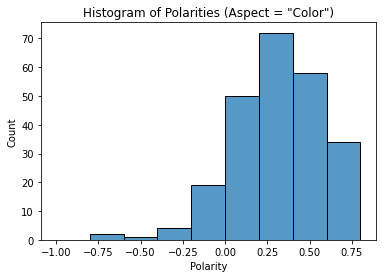

In [34]:
ax = sns.histplot(dataset["Polarity"],
                  bins=np.arange(-1,1,0.2)
                  ).set_title('Histogram of Polarities (Aspect = "Color")')
plt.show()

In [35]:
# save the chart figure
fig = ax.get_figure()
fig.savefig('Polarity_Distribution.png', 
            dpi=75, 
            bbox_inches="tight")

## Descriptor Analysis (n-gramming)

In [36]:
positives = dataset[dataset["Polarity"] > 0] # polarity greater than 0
negatives = dataset[dataset["Polarity"] < 0] # polarity less than 0

In [37]:
def ngrams(text, n):
     return zip(*[text[i:] for i in range(n)])
     
def display_ngram_frequency(corpus, n, display):
    """
    Generate a DataFrame of n-grams and their frequencies.
    """
    ngram_counts = Counter(ngrams(corpus.split(), n))
    most_commmon = ngram_counts.most_common(display)

    ngram = []
    count = []
    for i in range(0,len(most_commmon)):
        ngram.append(" ".join(most_commmon[i][0]))
        count.append(most_commmon[i][1])

    if n > 3:
        col = f"{n}-gram"
    if n == 3:
        col = 'Tri-gram'
    if n == 2:
        col = 'Bi-gram'

    return pd.DataFrame(zip(ngram, count), columns=[col, "Count"])

In [38]:
# list all negative descriptors in a single string
descriptors_negative_opinions = negatives["Descriptors"].tolist()
descriptors_negative_opinions = " ".join(descriptors_negative_opinions)

# positives
descriptors_positive_opinions = positives["Descriptors"].tolist()
descriptors_positive_opinions = " ".join(descriptors_positive_opinions)

In [39]:
display_ngram_frequency(descriptors_negative_opinions, n=3, display=10)

,Tri-gram,Count
0,than little disappointed,1
1,little disappointed darker,1
2,disappointed darker green,1
3,darker green other,1
4,green other main,1
5,other main awful,1
6,main awful not,1
7,awful not true,1
8,not true other,1
9,true other pretty,1


## WordClouds

In [40]:
from wordcloud import WordCloud

def generate_wordcloud(text):
    """
    Generate word cloud images.
    """
    wordcloud = WordCloud(collocations=False, 
                          background_color="black",
                          max_words=50).generate(text)
    
    # set the figure size
    plt.figure(figsize=[8,10])

    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")

    # remove plot axes
    plt.axis("off")

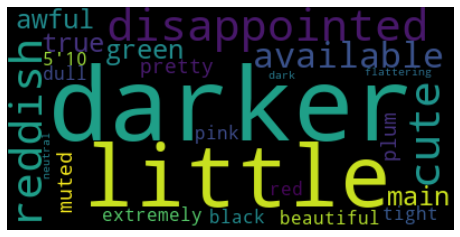

In [43]:
# WordCloud: descriptors extracted from negative opinions
generate_wordcloud(descriptors_negative_opinions)

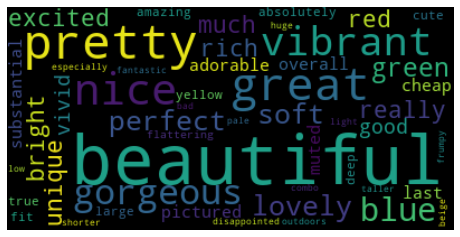

In [44]:
# WordCloud: descriptors extracted from positive opinions
generate_wordcloud(descriptors_positive_opinions)

## Examples

In [45]:
opinions = ["the color was beautiful",
            "gorgeous colors",
            "i ordered the red, it is a beautiful, vibrant, festive color",
            "the colors were very bland and the flowers just hang",
            "the color was not vibrant like photos show", 
            ]

In [46]:
df_examples = pd.DataFrame(opinions, columns=["Opinion"])
df_examples["Polarity"] = df_examples["Opinion"].apply(polarity) # polarity
df_examples['Descriptors'] = df_examples['Opinion'].apply(dependency_matching) # extract adjectives/adverbs

In [47]:
df_examples

,Opinion,Polarity,Descriptors
0,the color was beautiful,0.85,beautiful
1,gorgeous colors,0.70,gorgeous
2,"i ordered the red, it is a beautiful, vibrant, festive color",0.34,beautiful vibrant festive
3,the colors were very bland and the flowers just hang,-0.22,very bland
4,the color was not vibrant like photos show,-0.08,not vibrant
